# Imports and Configs

In [1]:
import os
import random
import cv2
import shutil
import numpy as np
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt


# Reproducibility
random.seed(42)
np.random.seed(42)


# CONFIGS
IMG_SIZE = 640
SOURCE_DIR = "/kaggle/input/diabetic-retinopathy-resized-arranged"
TARGET_DIR = "processed_balanced_640px"
CLASSES = ['0', '1', '2', '3', '4']

TARGET_COUNTS = {
    '0': 5000,   # Downsampling from 25k
    '1': 3500,   # Mild gently oversampled
    '2': 5000,   # VERY slightly downsampling
    '3': 2500,   # Heavy oversampling from 873
    '4': 2500    # Heavy oversampling from 708
}


# Data Preprocessing with Augmentation + Ben Garham

In [2]:

# AUGMENTOR 
augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=20, p=0.7),
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.1,
        p=0.5
    ),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.1,
        rotate_limit=0,
        p=0.5
    )
])

# BEN GRAHAM 
def apply_ben_graham(img, size=IMG_SIZE):
    if img is None:
        return None

    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Auto-crop black borders
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mask = gray > 10
    if image[np.ix_(mask.any(1), mask.any(0))].size > 0:
        image = image[np.ix_(mask.any(1), mask.any(0))]

    image = cv2.resize(image, (size, size))
    image = cv2.addWeighted(
        image, 4,
        cv2.GaussianBlur(image, (0, 0), size / 30),
        -4, 128
    )

    return cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# MAIN DATA PREPROCESSOR 
def process_classes():
    if os.path.exists(TARGET_DIR):
        shutil.rmtree(TARGET_DIR)
    os.makedirs(TARGET_DIR, exist_ok=True)

    for cls in CLASSES:
        src = os.path.join(SOURCE_DIR, cls)
        dst = os.path.join(TARGET_DIR, cls)
        os.makedirs(dst, exist_ok=True)

        images = os.listdir(src)
        target = TARGET_COUNTS[cls]

        print(f"\nProcessing Class {cls} ({len(images)} → {target})")

        # Case 1: Downsample / Keep 
        if len(images) >= target:
            selected = random.sample(images, target)
            for img_name in tqdm(selected):
                img = cv2.imread(os.path.join(src, img_name))
                processed = apply_ben_graham(img)
                if processed is None:
                    continue
                cv2.imwrite(os.path.join(dst, img_name), processed)

        # Case 2: Oversample via augmentation 
        else:
            processed_images = []

            # Step 1: Ben Graham ONCE on originals
            for img_name in images:
                img = cv2.imread(os.path.join(src, img_name))
                processed = apply_ben_graham(img)
                if processed is None:
                    continue

                cv2.imwrite(os.path.join(dst, img_name), processed)
                processed_images.append((img_name, processed))

            # Step 2: Augment already-processed images
            num_to_augment = target - len(processed_images)
            for i in tqdm(range(num_to_augment)):
                base_name, base_img = random.choice(processed_images)

                augmented = augmentor(image=base_img)["image"]

                cv2.imwrite(
                    os.path.join(dst, f"aug_{i}_{base_name}"),
                    augmented
                )


process_classes()

# Zip dataset
shutil.make_archive("processed_DR_balanced", "zip", TARGET_DIR)
print("\nDone! Saved as: processed_DR_balanced.zip")


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



Processing Class 0 (25810 → 5000)


100%|██████████| 5000/5000 [12:03<00:00,  6.91it/s]



Processing Class 1 (2443 → 3500)


100%|██████████| 1057/1057 [00:08<00:00, 129.21it/s]



Processing Class 2 (5292 → 5000)


100%|██████████| 5000/5000 [12:10<00:00,  6.85it/s]



Processing Class 3 (873 → 2500)


100%|██████████| 1627/1627 [00:12<00:00, 127.97it/s]



Processing Class 4 (708 → 2500)


100%|██████████| 1792/1792 [00:13<00:00, 131.46it/s]



Done! Saved as: processed_DR_balanced.zip


In [3]:
from IPython.display import FileLink
FileLink(r'processed_DR_balanced.zip')

/kaggle/working/processed_DR_balanced.zip

# Quick Visual Check


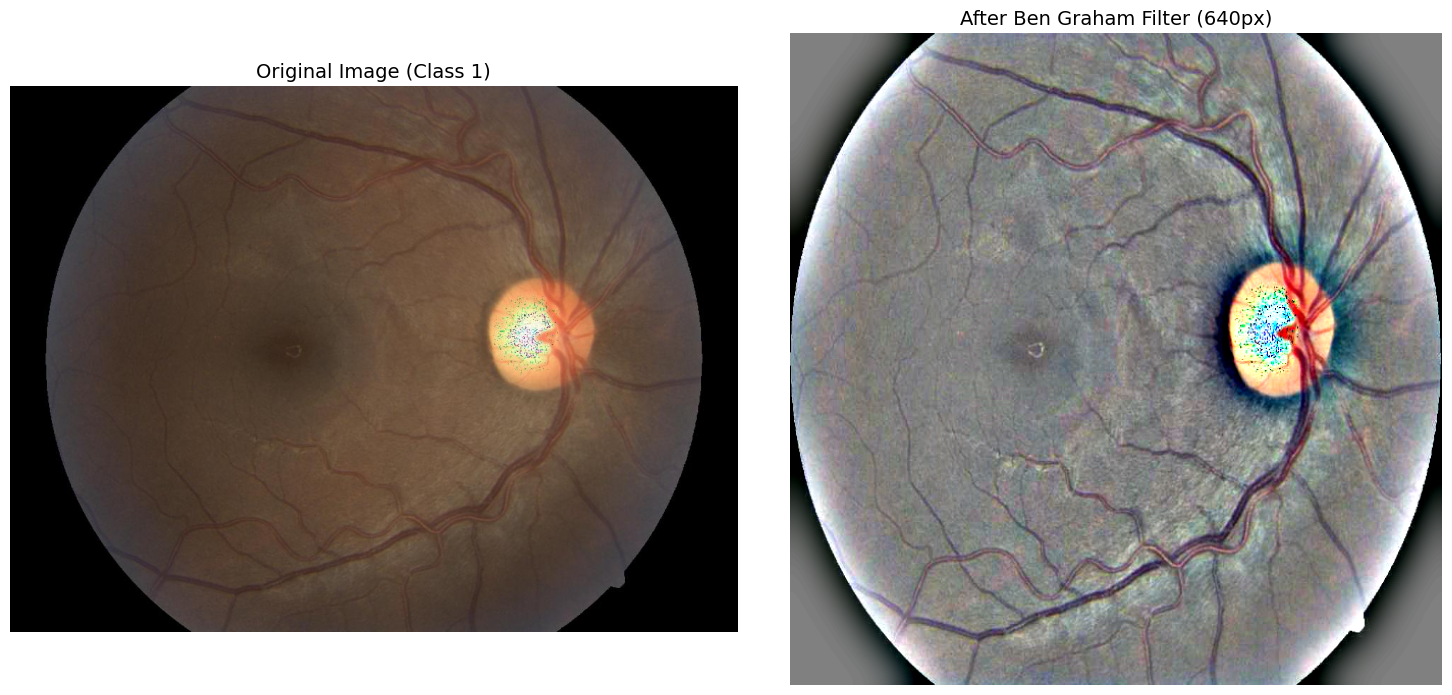

In [4]:
import matplotlib.pyplot as plt
import random
import cv2
import os

def showcase_preprocessing(source_dir, class_id='1'):
    # Random image from the selected class (e.g., Mild)
    class_path = os.path.join(source_dir, class_id)
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)
    
    # Read original and convert for plotting
    original_bgr = cv2.imread(img_path)
    original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)
    
    # Apply Ben Graham filter (using your existing function)
    processed_bgr = apply_ben_graham(original_bgr) 
    processed_rgb = cv2.cvtColor(processed_bgr, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(15, 7))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_rgb)
    plt.title(f"Original Image (Class {class_id})", fontsize=14)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(processed_rgb)
    plt.title("After Ben Graham Filter (640px)", fontsize=14)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

showcase_preprocessing(SOURCE_DIR, class_id='1')

# Summary

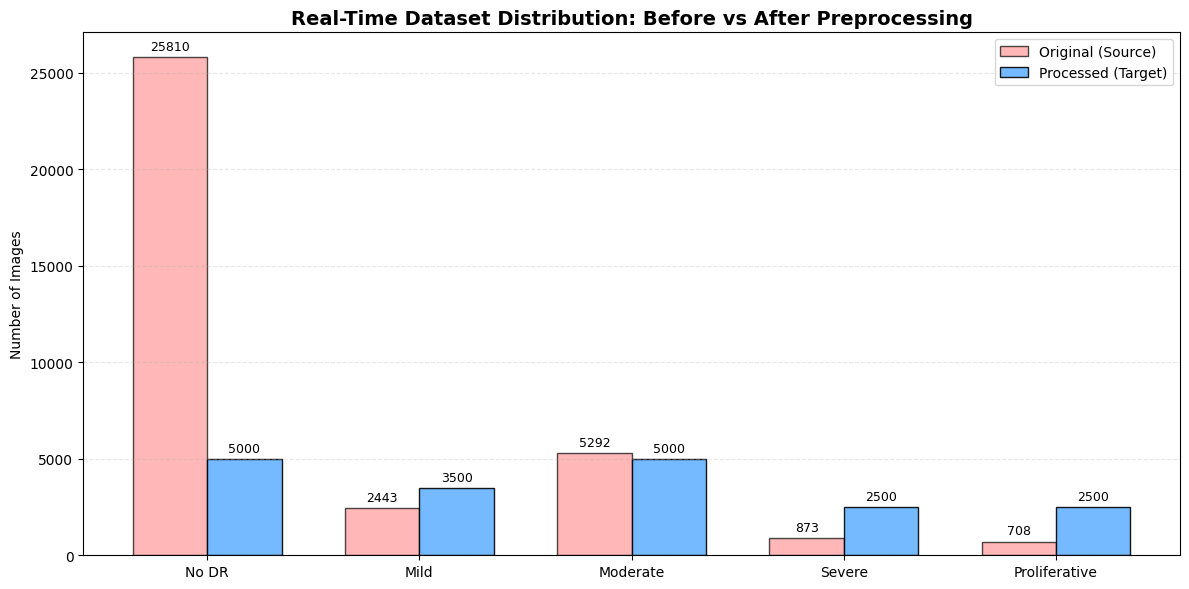

In [5]:

CLASS_MAP = {
    '0': 'No DR',
    '1': 'Mild',
    '2': 'Moderate',
    '3': 'Severe',
    '4': 'Proliferative'
}

# DYNAMIC COUNTING 
classes = sorted(CLASS_MAP.keys())
original_counts = []
balanced_counts = []
class_labels = [CLASS_MAP[c] for c in classes]

for cls in classes:
    # Count actual files in the Original Source
    orig_path = os.path.join(SOURCE_DIR, cls)
    if os.path.exists(orig_path):
        original_counts.append(len(os.listdir(orig_path)))
    else:
        original_counts.append(0)
        
    # Count actual files in your new Processed Folder
    bal_path = os.path.join(TARGET_DIR, cls)
    if os.path.exists(bal_path):
        balanced_counts.append(len(os.listdir(bal_path)))
    else:
        balanced_counts.append(0)

# PLOTTING 
x = np.arange(len(class_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, original_counts, width, label='Original (Source)', color='#FF9999', alpha=0.7, edgecolor='black')
rects2 = ax.bar(x + width/2, balanced_counts, width, label='Processed (Target)', color='#66B2FF', alpha=0.9, edgecolor='black')

# Styling
ax.set_ylabel('Number of Images')
ax.set_title('Real-Time Dataset Distribution: Before vs After Preprocessing', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.legend()

# Label each bar with the actual count found on disk
ax.bar_label(rects1, padding=3, fontsize=9)
ax.bar_label(rects2, padding=3, fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()